## Import library

In [1]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

## Import model(VGG)

In [2]:
import sys
sys.path.append('/kaggle/input/vgg/pytorch/default/1')
from vgg import vgg

## 設定超參數(填空)

In [3]:
SPARSITY_REGULARIZATION = True
# Tested with 0, 1e-5, 1e-4
LAMBDAs = [0, 1e-5, 1e-4]

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 60
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

In [4]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集
這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [5]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

100%|██████████| 170M/170M [00:02<00:00, 66.3MB/s]


In [6]:
def updateBN(lambda_val):
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
         m.weight.grad.data.add_(lambda_val * torch.sign(m.weight.data))

## 定義訓練跟測試函數

In [7]:
#### 訓練函數 #####

train_acc_histories = {l: [] for l in LAMBDAs}

def train(epoch, lambda_val, model, optimizer):
    model.train()
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN(lambda_val)
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        total += target.size(0)

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [lambda={}] [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch+1, lambda_val, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    # Record training accuracy for this epoch
    train_acc = 100. * correct / total
    train_acc_histories[lambda_val].append(train_acc)
    print('Train Epoch: {} [lambda={}] Accuracy: {}/{} ({:.1f}%)'.format(
        epoch + 1, lambda_val, correct, total, train_acc))


In [8]:
#### 測試函數 ####
def test(model):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))

In [9]:
for lambda_val in LAMBDAs:
    print(f'\n=== Training with lambda={lambda_val} ===\n')

    # Define model and optimizer
    model = vgg()
    if CUDA:
        model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    WEIGHT_PATH = f'./model_best_lambda_{lambda_val}.pth'

    best_prec1 = 0.

    if(RESUME):
        checkpoint = torch.load(WEIGHT_PATH)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        START_EPOCH = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        print(f'RESUME MODEL @EPOCH={START_EPOCH}, BEST_PREC1={best_prec1}')

    for epoch in range(START_EPOCH, EPOCHS):
        # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
        if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        train(epoch, lambda_val, model, optimizer)
        prec1 = test(model)

        # 儲存模型權重，方便做後續剪枝,後續訓練
        if(prec1 > best_prec1):
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
                'optimizer': optimizer.state_dict(),
            }, WEIGHT_PATH)

        best_prec1 = max(prec1, best_prec1)


=== Training with lambda=0 ===

Train Epoch: 1 [lambda=0] [0/50000 (0.0%)]	Loss: 2.303283
Train Epoch: 1 [lambda=0] [10000/50000 (20.0%)]	Loss: 1.819772
Train Epoch: 1 [lambda=0] [20000/50000 (40.0%)]	Loss: 1.583842
Train Epoch: 1 [lambda=0] [30000/50000 (60.0%)]	Loss: 1.268485
Train Epoch: 1 [lambda=0] [40000/50000 (80.0%)]	Loss: 1.206672
Train Epoch: 1 [lambda=0] Accuracy: 22100/50000 (44.2%)

Test set: Average loss: 1.3433, Accuracy: 5647/10000 (56.5%)

Train Epoch: 2 [lambda=0] [0/50000 (0.0%)]	Loss: 1.001288
Train Epoch: 2 [lambda=0] [10000/50000 (20.0%)]	Loss: 0.769276
Train Epoch: 2 [lambda=0] [20000/50000 (40.0%)]	Loss: 0.904646
Train Epoch: 2 [lambda=0] [30000/50000 (60.0%)]	Loss: 1.083264
Train Epoch: 2 [lambda=0] [40000/50000 (80.0%)]	Loss: 1.094817
Train Epoch: 2 [lambda=0] Accuracy: 32402/50000 (64.8%)

Test set: Average loss: 0.8358, Accuracy: 7141/10000 (71.4%)

Train Epoch: 3 [lambda=0] [0/50000 (0.0%)]	Loss: 0.872624
Train Epoch: 3 [lambda=0] [10000/50000 (20.0%)]	Los

## 繪製Sparsity-Training結果圖

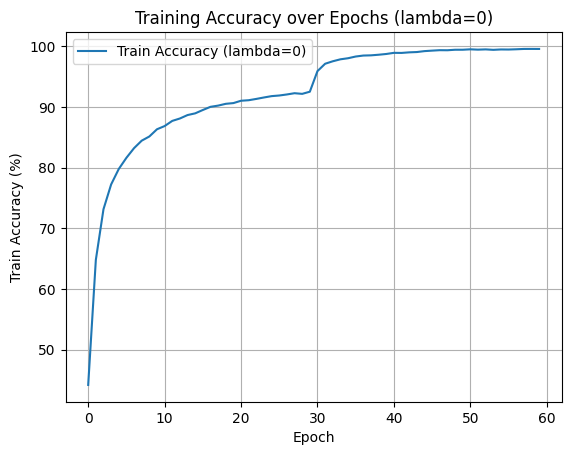

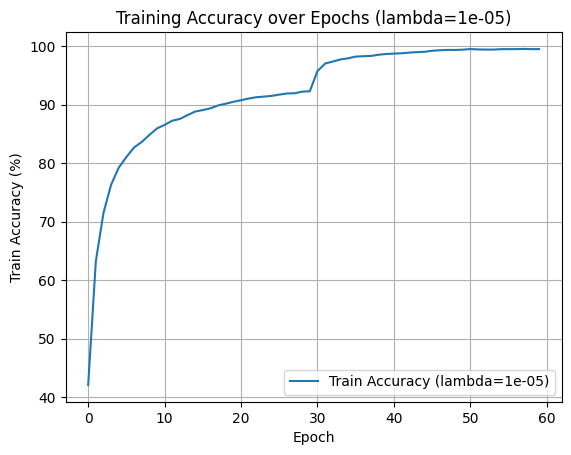

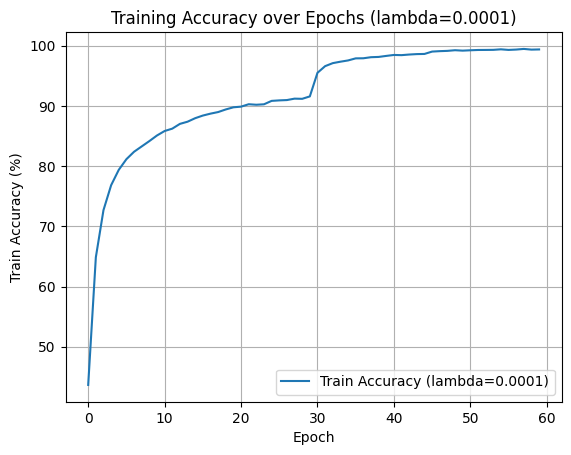

In [10]:
#繪製 Sparsity-Training 結果圖

for lambda_val in LAMBDAs:
    plt.plot(range(START_EPOCH, EPOCHS), train_acc_histories[lambda_val], label=f'Train Accuracy (lambda={lambda_val})')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy (%)')
    plt.title(f'Training Accuracy over Epochs (lambda={lambda_val})')
    plt.legend()
    plt.grid(True)
    plt.show()

## 繪製scaling factor 分布圖

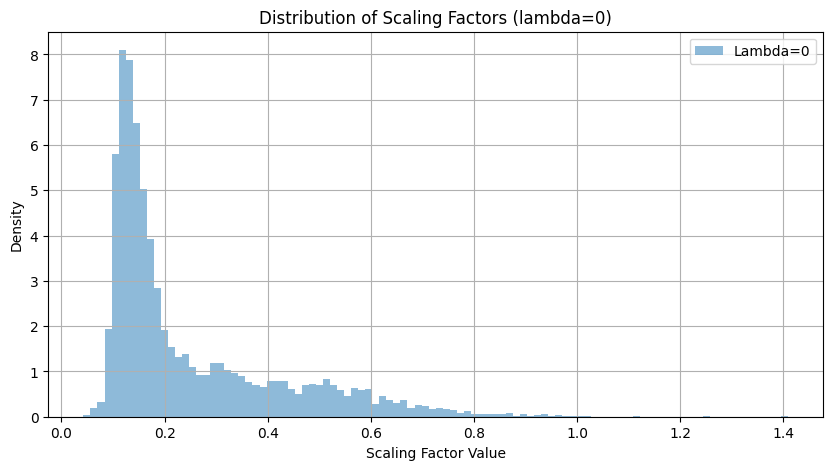

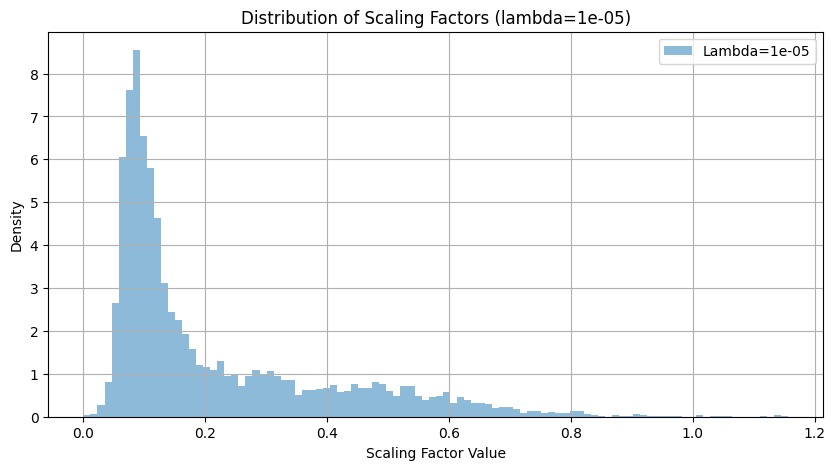

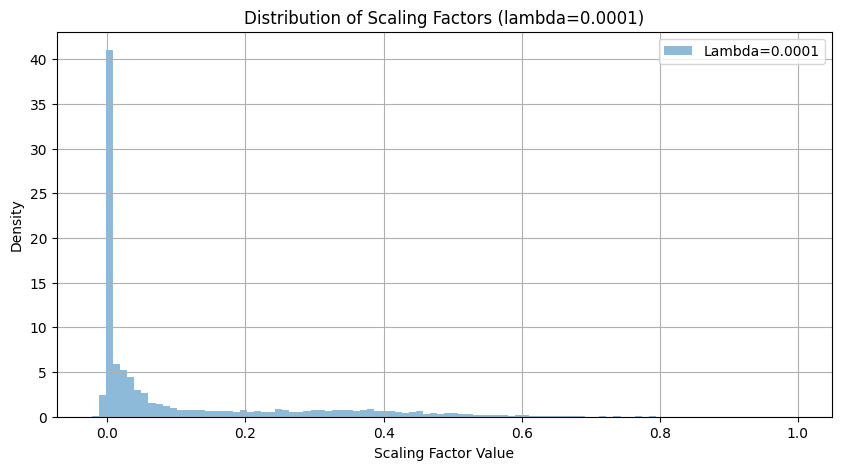

In [11]:
#繪製 scaling factor 分布圖

for lambda_val in LAMBDAs:
    model = vgg()
    if CUDA:
        model.cuda()
    checkpoint = torch.load(f'./model_best_lambda_{lambda_val}.pth')
    model.load_state_dict(checkpoint['state_dict'])

    scaling_factors = []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            scaling_factors.append(m.weight.data.cpu().numpy())
    scaling_factors = np.concatenate(scaling_factors)

    plt.figure(figsize=(10, 5))
    plt.hist(scaling_factors, bins=100, density=True, alpha=0.5, label=f'Lambda={lambda_val}')
    plt.xlabel('Scaling Factor Value')
    plt.ylabel('Density')
    plt.title(f'Distribution of Scaling Factors (lambda={lambda_val})')
    plt.legend()
    plt.grid(True)
    plt.show()